In [1]:
from google.colab import drive
drive.mount('/content/drive')

dirname = '/content/drive/My Drive/CattleGroup'

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import cv2
import glob
import string
from PIL import Image
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics


In [3]:
data_dir = Path(dirname)
dirs = data_dir.glob("*")

labels_dict = {" Holstein Friesian": 0, "Black Angus": 1,"Red Chittagong": 2, "Shahiwal": 3, "White Native": 4 }
labels2breed = {0:" Holstein Friesian", 1:"Black Angus", 2:"Red Chittagong", 3:"Shahiwal", 4:"White Native"}

labels = []
image_data = []

for label in dirs:
    image_label = label.parts[-1]
    cnt = 0
    print(image_label)
    for img_path in label.glob("*.jpg",):
        img = image.load_img(img_path, target_size=(100, 100))
        image_array = image.img_to_array(img)
        image_data.append(image_array)
        if image_label in labels_dict:
            labels.append(labels_dict[image_label])
        else:
            print("Label not found:", image_label)
        cnt += 1

    print(cnt)

Red Chittagong
1000
White Native
1000
Black Angus
1025
Shahiwal
1000
 Holstein Friesian
1000


In [4]:
batch_size = 12
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  dirname,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5025 files belonging to 5 classes.
Using 3518 files for training.


In [5]:
test_ds = tf.keras.utils.image_dataset_from_directory(
   dirname,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5025 files belonging to 5 classes.
Using 1507 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

[' Holstein Friesian', 'Black Angus', 'Red Chittagong', 'Shahiwal', 'White Native']


In [7]:
# Get class names
class_names = train_ds.class_names

# Extract x_train, y_train from train_ds
x_train = []
y_train = []
for images, labels in train_ds:
    x_train.append(images)
    y_train.append(labels)
x_train = np.concatenate(x_train)
y_train = np.concatenate(y_train)

# Extract x_test, y_test from test_ds
x_test = []
y_test = []
for images, labels in test_ds:
    x_test.append(images)
    y_test.append(labels)
x_test = np.concatenate(x_test)
y_test = np.concatenate(y_test)

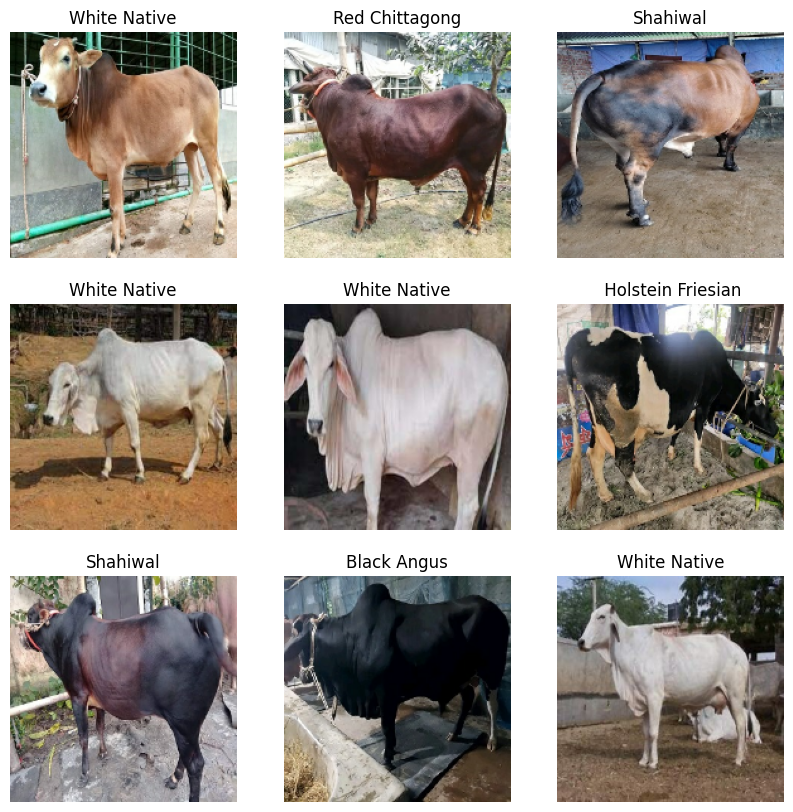

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(12, 180, 180, 3)
(12,)


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
normalization_layer = layers.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))


0.0 1.0


**CNN**

In [13]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

Epoch 1/10
294/294 [==============================] - 169s 567ms/step - loss: 0.7480 - accuracy: 0.7229 - val_loss: 0.3307 - val_accuracy: 0.8912
Epoch 2/10
294/294 [==============================] - 169s 575ms/step - loss: 0.1977 - accuracy: 0.9360 - val_loss: 0.1560 - val_accuracy: 0.9529
Epoch 3/10
294/294 [==============================] - 166s 566ms/step - loss: 0.0619 - accuracy: 0.9798 - val_loss: 0.0995 - val_accuracy: 0.9735
Epoch 4/10
294/294 [==============================] - 167s 569ms/step - loss: 0.0287 - accuracy: 0.9923 - val_loss: 0.0658 - val_accuracy: 0.9841
Epoch 5/10
294/294 [==============================] - 163s 554ms/step - loss: 0.0062 - accuracy: 0.9989 - val_loss: 0.0786 - val_accuracy: 0.9827
Epoch 6/10
294/294 [==============================] - 169s 577ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0818 - val_accuracy: 0.9814
Epoch 7/10
294/294 [==============================] - 159s 543ms/step - loss: 1.8444e-04 - accuracy: 1.0000 - val_loss: 0.06

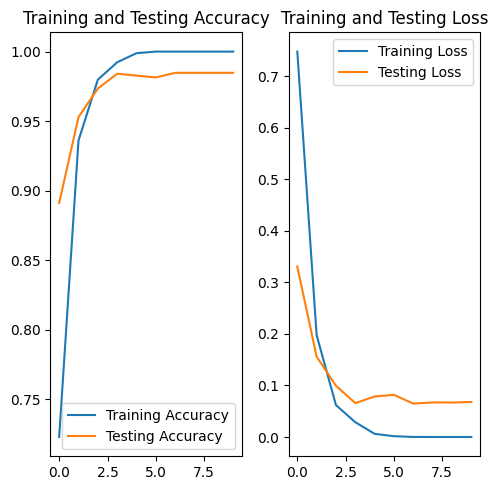

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Testing Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Testing Loss')
plt.legend(loc='upper right')
plt.title('Training and Testing Loss')
plt.subplots_adjust(wspace=0.4)
plt.tight_layout()
plt.show()


In [17]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

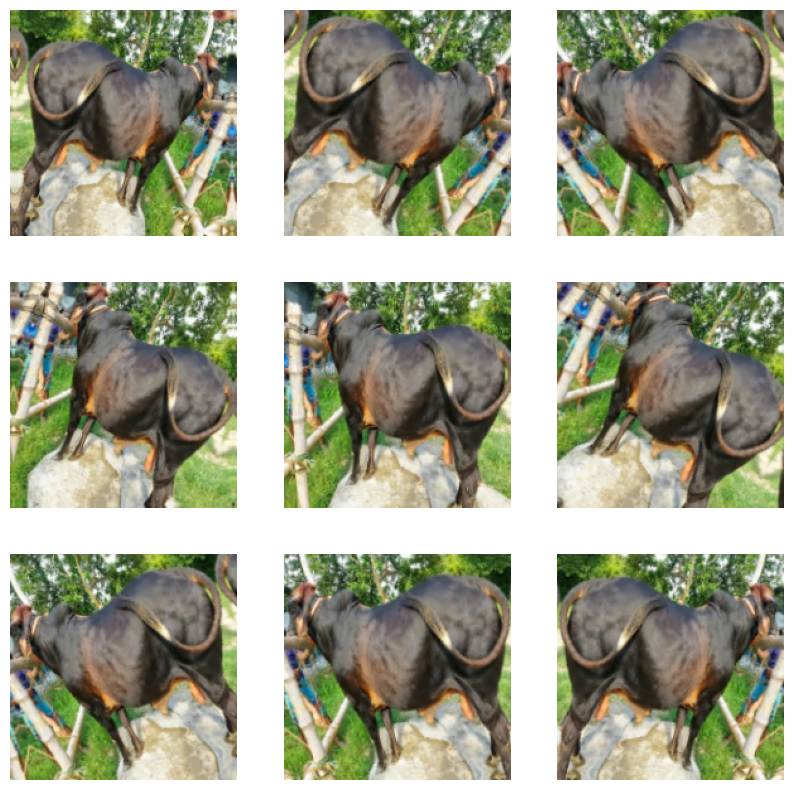

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [19]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

Epoch 1/15
294/294 [==============================] - 185s 623ms/step - loss: 0.8763 - accuracy: 0.6569 - val_loss: 0.6838 - val_accuracy: 0.7631
Epoch 2/15
294/294 [==============================] - 180s 611ms/step - loss: 0.5486 - accuracy: 0.8059 - val_loss: 0.4726 - val_accuracy: 0.8407
Epoch 3/15
294/294 [==============================] - 190s 648ms/step - loss: 0.4654 - accuracy: 0.8323 - val_loss: 0.5034 - val_accuracy: 0.8334
Epoch 4/15
294/294 [==============================] - 185s 631ms/step - loss: 0.3839 - accuracy: 0.8616 - val_loss: 0.3259 - val_accuracy: 0.8872
Epoch 5/15
294/294 [==============================] - 183s 623ms/step - loss: 0.3407 - accuracy: 0.8775 - val_loss: 0.6087 - val_accuracy: 0.7837
Epoch 6/15
294/294 [==============================] - 184s 627ms/step - loss: 0.3303 - accuracy: 0.8829 - val_loss: 0.3420 - val_accuracy: 0.8752
Epoch 7/15
294/294 [==============================] - 185s 629ms/step - loss: 0.2499 - accuracy: 0.9102 - val_loss: 0.2235 -

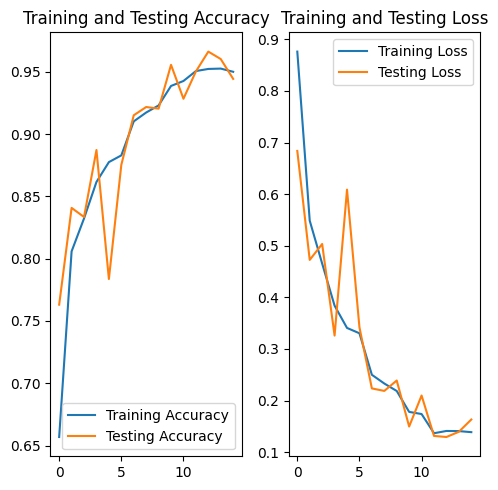

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Testing Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Testing Loss')
plt.legend(loc='upper right')
plt.title('Training and Testing Loss')

plt.subplots_adjust(wspace=0.4)
plt.tight_layout()
plt.show()
plt.show()

1/1 [==============================] - 0s 35ms/step
This image belongs to  Holstein Friesian and Accuracy 100.00 %.


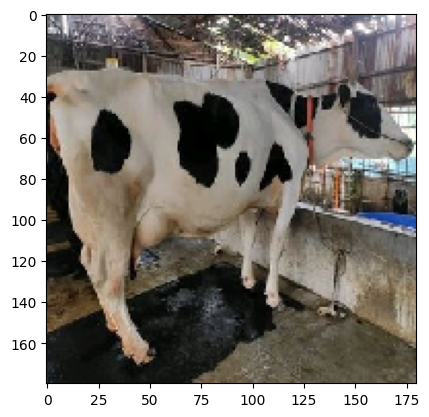

In [31]:
img=tf.keras.utils.load_img("/content/c (86).jpg",target_size=(180,180))
plt.imshow(img)
img_array=tf.keras.utils.img_to_array(img)
img_array=tf.expand_dims(img_array,0)
pred=model.predict(img_array)
score=tf.nn.softmax(pred[0])

print(
    "This image belongs to {} and Accuracy {:.2f} %."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

126/126 [==============================] - 18s 142ms/step


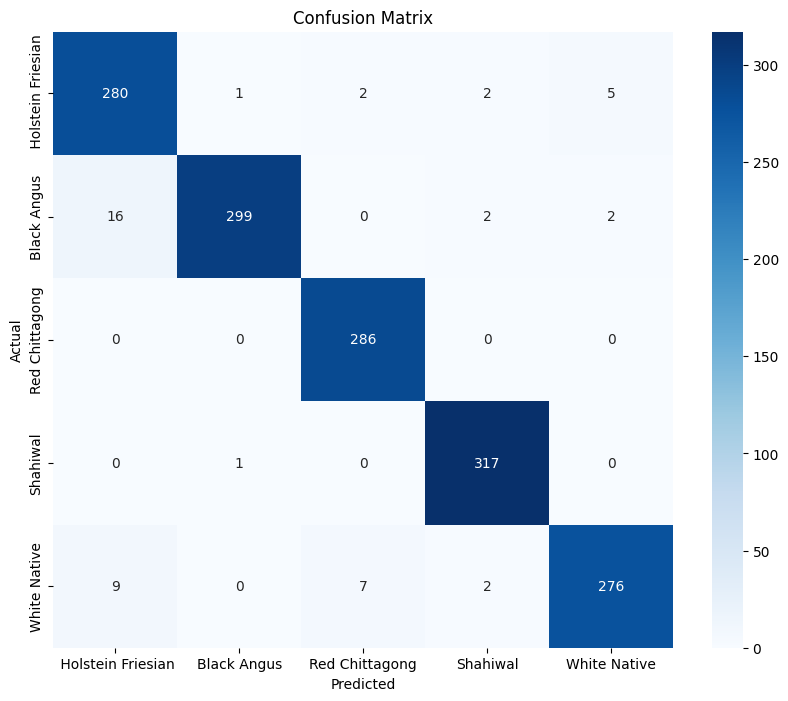

Classification Report:
                    precision    recall  f1-score   support

 Holstein Friesian       0.92      0.97      0.94       290
       Black Angus       0.99      0.94      0.96       319
    Red Chittagong       0.97      1.00      0.98       286
          Shahiwal       0.98      1.00      0.99       318
      White Native       0.98      0.94      0.96       294

          accuracy                           0.97      1507
         macro avg       0.97      0.97      0.97      1507
      weighted avg       0.97      0.97      0.97      1507



In [ ]:
# Get predictions for the test dataset
predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels from the test dataset
true_labels = []
for images, labels in test_ds:
    true_labels.extend(labels.numpy())

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
report = classification_report(true_labels, predicted_classes, target_names=class_names)

# Print the classification report
print("Classification Report:")
print(report)

In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_labels, predicted_classes, target_names=class_names, output_dict=True)

# Calculate overall precision, recall, F1-score
precision = report['macro avg']['precision']
recall = report['macro avg']['recall']
f1_score = report['macro avg']['f1-score']

print(f"Overall Precision: {precision:.4f}")
print(f"Overall Recall: {recall:.4f}")
print(f"Overall F1-Score: {f1_score:.4f}")


Overall Precision: 0.9675
Overall Recall: 0.9677
Overall F1-Score: 0.9672


48/48 [==============================] - 25s 400ms/step


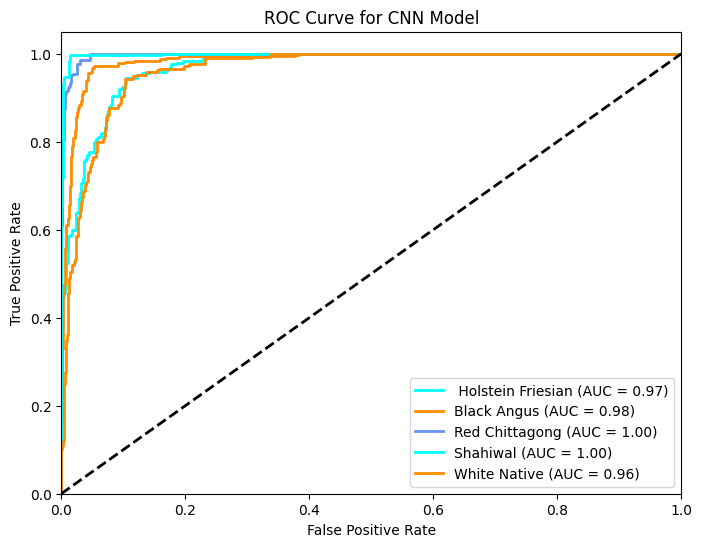

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))

# Compute probabilities of the test set
probabilities = model.predict(x_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC curves
plt.figure(figsize=(8, 6))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])  # You may need more colors for more classes
for i, color in zip(range(len(class_names)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} (AUC = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN Model')
plt.legend(loc="lower right")
plt.show()




**SVM**

In [ ]:
from sklearn import svm

# Data Preprocessing for Training
train_images = []
train_labels = []

for images, labels in train_ds:
    train_images.extend(images.numpy())
    train_labels.extend(labels.numpy())

train_images = np.array(train_images)
train_labels = np.array(train_labels)

train_images = train_images.reshape(train_images.shape[0], -1)
train_images = train_images.astype('float32') / 255.0

# Initialize and train the SVM model
svm_model = svm.SVC(kernel='linear')
svm_model.fit(train_images, train_labels)


SVC(kernel='linear')

In [ ]:
# Data Preprocessing for testing
val_images = []
val_labels = []

for images, labels in test_ds:
    val_images.extend(images.numpy())
    val_labels.extend(labels.numpy())

val_images = np.array(val_images)
val_labels = np.array(val_labels)

val_images = val_images.reshape(val_images.shape[0], -1)
val_images = val_images.astype('float32') / 255.0
val_predictions = svm_model.predict(val_images)



The predicted class for the unknown image is: White Native
Accuracy: 97.28%


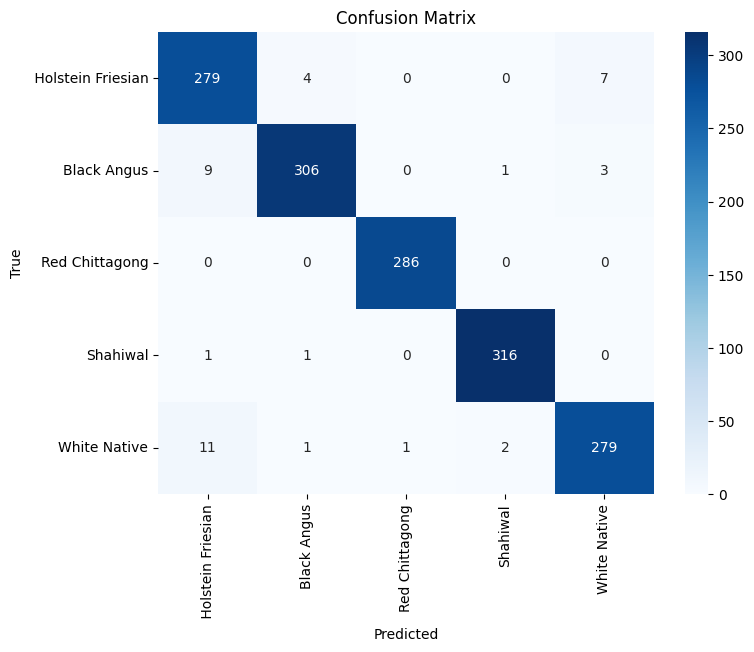

Classification Report:
                    precision    recall  f1-score   support

 Holstein Friesian       0.93      0.96      0.95       290
       Black Angus       0.98      0.96      0.97       319
    Red Chittagong       1.00      1.00      1.00       286
          Shahiwal       0.99      0.99      0.99       318
      White Native       0.97      0.95      0.96       294

          accuracy                           0.97      1507
         macro avg       0.97      0.97      0.97      1507
      weighted avg       0.97      0.97      0.97      1507



In [ ]:
# Prediction on a Single Image
image_path = '/content/asia (477).jpg'
img_height = 180
img_width = 180
image = Image.open(image_path)
image = image.resize((img_height, img_width))

image_array = np.array(image)
image_array = image_array.reshape(1, -1).astype('float32') / 255.0

predicted_class = svm_model.predict(image_array)[0]
predicted_class_name = class_names[predicted_class]

print(f"The predicted class for the unknown image is: {predicted_class_name}")

# Calculate accuracy
accuracy = accuracy_score(val_labels, val_predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")
conf_matrix = confusion_matrix(val_labels, val_predictions)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_report = classification_report(val_labels, val_predictions, target_names=class_names)

# Display classification report with class names
print("Classification Report:")
print(class_report)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1_score, _ = precision_recall_fscore_support(val_labels, val_predictions, average='weighted')

print(f"Overall Precision: {precision:.4f}")
print(f"Overall Recall: {recall:.4f}")
print(f"Overall F1-score: {f1_score:.4f}")

Overall Precision: 0.9731
Overall Recall: 0.9728
Overall F1-score: 0.9728


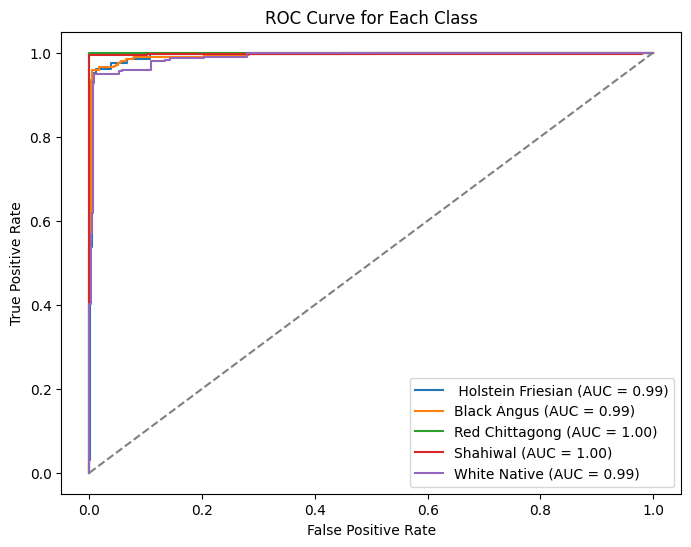

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class AUC-ROC calculation
num_classes = len(class_names)
binarized_val_labels = label_binarize(val_labels, classes=np.arange(num_classes))
val_probabilities = svm_model.decision_function(val_images)
# Calculate AUC-ROC for each class
auc_roc_per_class = []
plt.figure(figsize=(8, 6))

for i in range(num_classes):
    class_auc = roc_auc_score(binarized_val_labels[:, i], val_probabilities[:, i])
    auc_roc_per_class.append(class_auc)

    # Compute ROC curve for each class
    fpr, tpr, _ = roc_curve(binarized_val_labels[:, i], val_probabilities[:, i])
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {class_auc:.2f})')

# Plot ROC curve for each class
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='lower right')
plt.show()


# **Decesion Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Data Preprocessing for Training
train_images = []
train_labels = []

for images, labels in train_ds:
    train_images.extend(images.numpy())
    train_labels.extend(labels.numpy())

train_images = np.array(train_images)
train_labels = np.array(train_labels)

train_images = train_images.reshape(train_images.shape[0], -1)
train_images = train_images.astype('float32') / 255.0

# Initialize and train the Decision Tree model
decision_tree = DecisionTreeClassifier()
decision_tree.fit(train_images, train_labels)

# Data Preprocessing for testing
val_images = []
val_labels = []

for images, labels in test_ds:
    val_images.extend(images.numpy())
    val_labels.extend(labels.numpy())

val_images = np.array(val_images)
val_labels = np.array(val_labels)

val_images = val_images.reshape(val_images.shape[0], -1)
val_images = val_images.astype('float32') / 255.0

The predicted class for the unknown image is: White Native
Accuracy: 95.16%


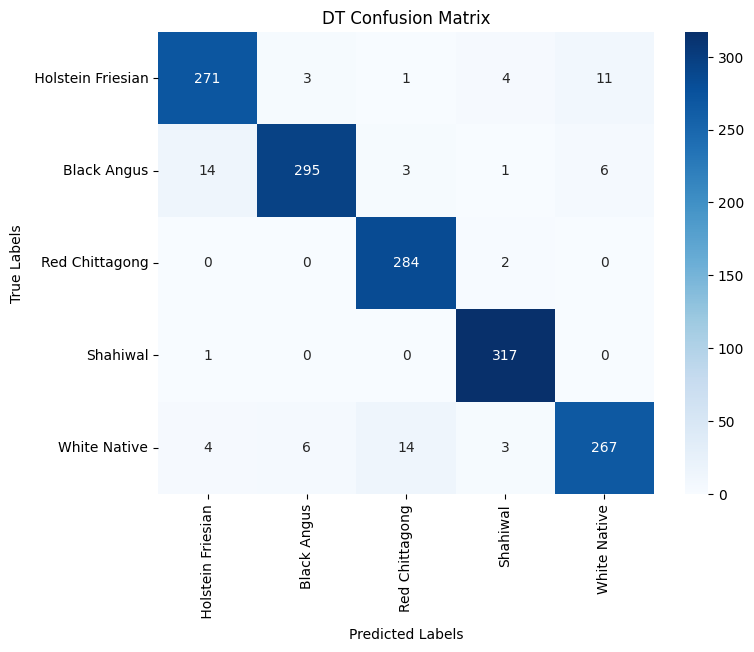

DT Classification Report:
                    precision    recall  f1-score   support

 Holstein Friesian       0.93      0.93      0.93       290
       Black Angus       0.97      0.92      0.95       319
    Red Chittagong       0.94      0.99      0.97       286
          Shahiwal       0.97      1.00      0.98       318
      White Native       0.94      0.91      0.92       294

          accuracy                           0.95      1507
         macro avg       0.95      0.95      0.95      1507
      weighted avg       0.95      0.95      0.95      1507



In [ ]:
# Prediction on a Single Image
image_path = '/content/asia (477).jpg'
img_height = 180
img_width = 180
image = Image.open(image_path)
image = image.resize((img_height, img_width))

image_array = np.array(image)
image_array = image_array.reshape(1, -1).astype('float32') / 255.0

predicted_class = decision_tree.predict(image_array)[0]
predicted_class_name = class_names[predicted_class]

print(f"The predicted class for the unknown image is: {predicted_class_name}")

# Testing Decision Tree model on the test set
val_predictions = decision_tree.predict(val_images)

# Calculate accuracy
accuracy = accuracy_score(val_labels, val_predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Plot confusion matrix
cm_knn = confusion_matrix(val_labels, val_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('DT Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plot classification report
report_dt = classification_report(val_labels, val_predictions, target_names=class_names)
print("DT Classification Report:")
print(report_dt)



In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1_score, _ = precision_recall_fscore_support(val_labels, val_predictions, average='weighted')

print(f"Overall Precision: {precision:.4f}")
print(f"Overall Recall: {recall:.4f}")
print(f"Overall F1-score: {f1_score:.4f}")

Overall Precision: 0.9517
Overall Recall: 0.9516
Overall F1-score: 0.9513


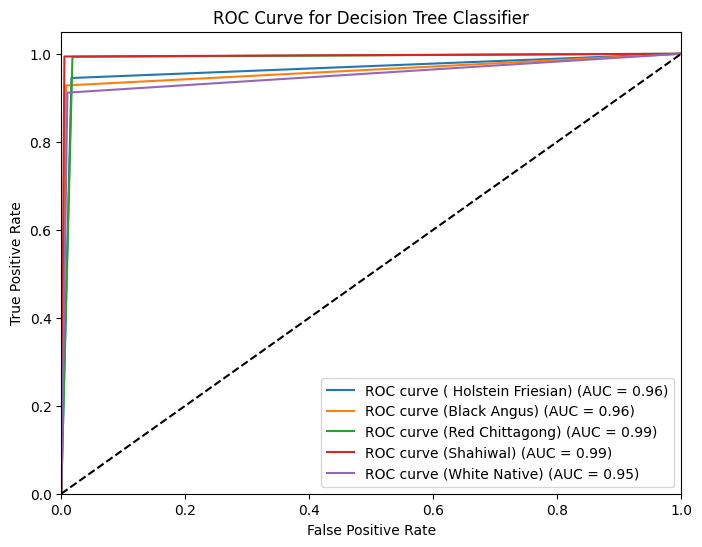

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert labels to one-hot encoded format
val_labels_bin = label_binarize(val_labels, classes=np.unique(val_labels))

# Get the decision scores for each class
val_scores = decision_tree.predict_proba(val_images)

# Compute ROC curve and ROC area for each class
n_classes = len(class_names)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(val_labels_bin[:, i], val_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve ({class_names[i]}) (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree Classifier')
plt.legend(loc="lower right")
plt.show()

# **KNN**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Extract features using a pre-trained CNN (e.g., VGG16)
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
# Remove the classification layers
feature_extractor = tf.keras.models.Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)
# Extract features from the training dataset
train_features = []
train_labels = []
for images, labels in train_ds:
    features = feature_extractor.predict(images)
    train_features.append(features)
    train_labels.append(labels.numpy())

train_features = np.concatenate(train_features)
train_features = train_features.reshape(train_features.shape[0], -1)  # Flatten the features
train_labels = np.concatenate(train_labels)

# Train KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(train_features, train_labels)




1/1 [==============================] - 4s 4s/step


KNeighborsClassifier()

In [ ]:
val_features = []
val_labels = []
for images, labels in test_ds:
    features = feature_extractor.predict(images)
    val_features.append(features)
    val_labels.append(labels.numpy())

val_features = np.concatenate(val_features)
val_features = val_features.reshape(val_features.shape[0], -1)
val_labels = np.concatenate(val_labels)

val_predictions = knn_model.predict(val_features)

1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 1s 676ms/step
The predicted class for the unknown image is: White Native
 Accuracy: 98.08%


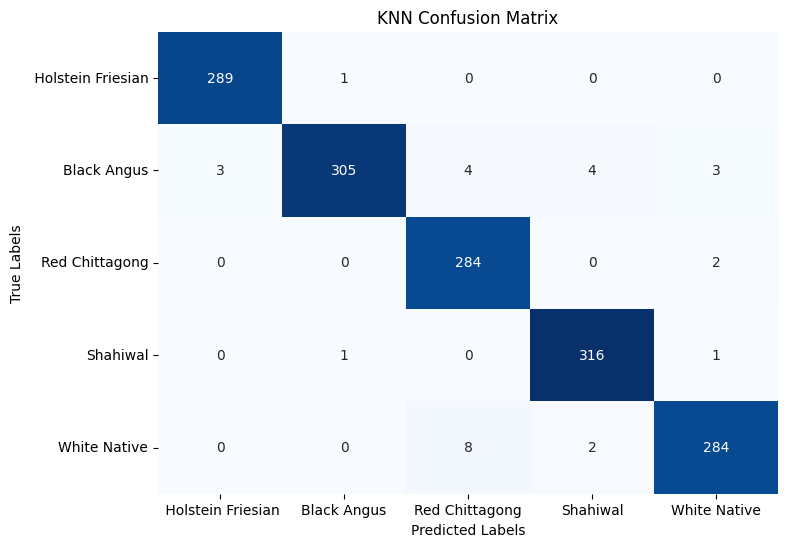

KNN Classification Report:
                    precision    recall  f1-score   support

 Holstein Friesian       0.99      1.00      0.99       290
       Black Angus       0.99      0.96      0.97       319
    Red Chittagong       0.96      0.99      0.98       286
          Shahiwal       0.98      0.99      0.99       318
      White Native       0.98      0.97      0.97       294

          accuracy                           0.98      1507
         macro avg       0.98      0.98      0.98      1507
      weighted avg       0.98      0.98      0.98      1507



In [ ]:
new_img = tf.keras.utils.load_img("/content/asia (477).jpg", target_size=(img_height, img_width))
new_img_array = tf.keras.utils.img_to_array(new_img)
new_img_array = np.expand_dims(new_img_array, axis=0)

# Extract features from the new image
new_img_features = feature_extractor.predict(new_img_array)
new_img_features = new_img_features.reshape(1, -1)

# Use the KNN model to predict the class
predicted_class = knn_model.predict(new_img_features)
predicted_class_name = class_names[int(predicted_class)]
print(f"The predicted class for the unknown image is: {predicted_class_name}")

# Calculate accuracy
accuracy = accuracy_score(val_labels, val_predictions)
print(f" Accuracy: {accuracy * 100:.2f}%")

# Plot confusion matrix
cm_knn = confusion_matrix(val_labels, val_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, cmap='Blues', fmt='d', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plot classification report
report_knn = classification_report(val_labels, val_predictions, target_names=class_names)
print("KNN Classification Report:")
print(report_knn)


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, _ = precision_recall_fscore_support(val_labels, val_predictions, average='weighted')
print(f"Overall Precision: {precision:.4f}")
print(f"Overall Recall: {recall:.4f}")
print(f"Overall F1-score: {f1_score:.4f}")


Overall Precision: 0.9095
Overall Recall: 0.9084
Overall F1-score: 0.9083


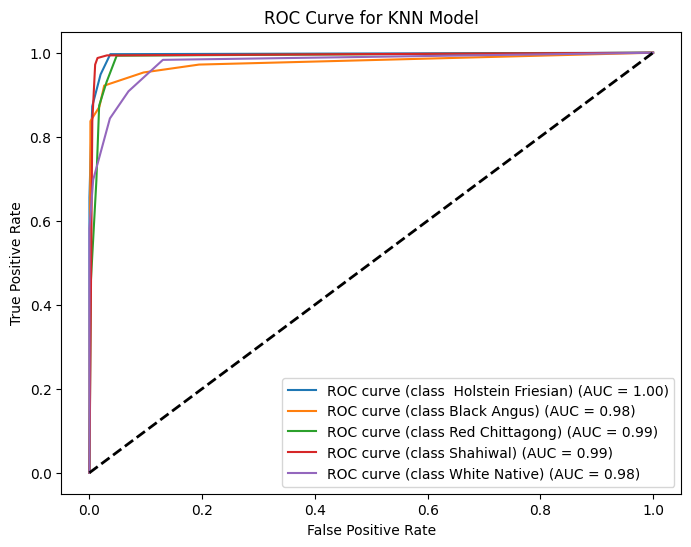

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute probabilities for each class
val_probs = knn_model.predict_proba(val_features)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(val_labels == i, val_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {class_names[i]}) (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for KNN Model')
plt.legend(loc='lower right')
plt.show()


# **RANDOM FOREST**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Extract features using a pre-trained CNN (e.g., VGG16)
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
feature_extractor = tf.keras.models.Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)

# Extract features from the training dataset
train_features = []
train_labels = []
for images, labels in train_ds:
    features = feature_extractor.predict(images)
    train_features.append(features)
    train_labels.append(labels.numpy())

train_features = np.concatenate(train_features)
train_features = train_features.reshape(train_features.shape[0], -1)  # Flatten the features
train_labels = np.concatenate(train_labels)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=123)
rf_model.fit(train_features, train_labels)


1/1 [==============================] - 6s 6s/step


RandomForestClassifier(random_state=123)

In [ ]:
val_features = []
val_labels = []
for images, labels in test_ds:
    features = feature_extractor.predict(images)
    val_features.append(features)
    val_labels.append(labels.numpy())

val_features = np.concatenate(val_features)
val_features = val_features.reshape(val_features.shape[0], -1)
val_labels = np.concatenate(val_labels)
val_predictions = rf_model.predict(val_features)

1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 0s 369ms/step
The predicted class for the unknown image is: White Native
Accuracy: 98.08%


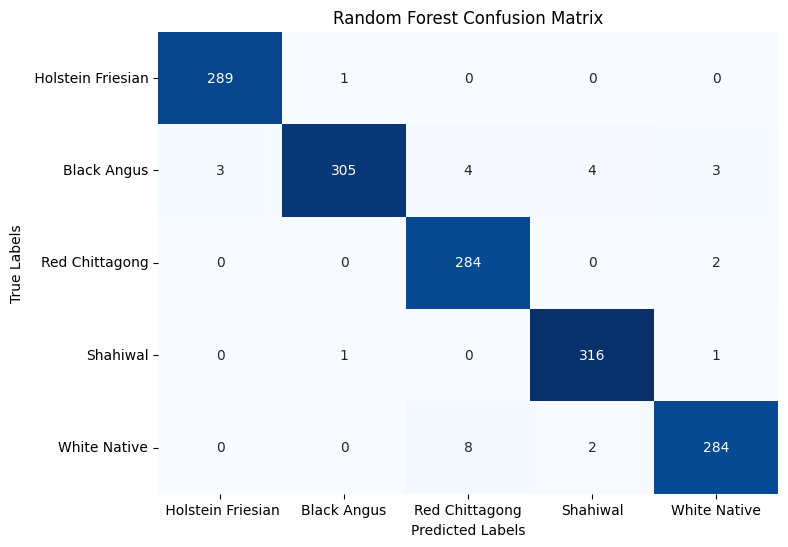

Random Forest Classification Report:
                    precision    recall  f1-score   support

 Holstein Friesian       0.99      1.00      0.99       290
       Black Angus       0.99      0.96      0.97       319
    Red Chittagong       0.96      0.99      0.98       286
          Shahiwal       0.98      0.99      0.99       318
      White Native       0.98      0.97      0.97       294

          accuracy                           0.98      1507
         macro avg       0.98      0.98      0.98      1507
      weighted avg       0.98      0.98      0.98      1507



In [ ]:
# Load and preprocess the new image
new_img = tf.keras.utils.load_img("/content/asia (477).jpg", target_size=(img_height, img_width))
new_img_array = tf.keras.utils.img_to_array(new_img)
new_img_array = np.expand_dims(new_img_array, axis=0)

# Extract features from the new image
new_img_features = feature_extractor.predict(new_img_array)
new_img_features = new_img_features.reshape(1, -1)

# Use the Random Forest model to predict the class
predicted_class = rf_model.predict(new_img_features)
predicted_class_name = class_names[int(predicted_class)]
print(f"The predicted class for the unknown image is: {predicted_class_name}")

# Calculate accuracy
accuracy = accuracy_score(val_labels, val_predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Plot confusion matrix
cm_rf = confusion_matrix(val_labels, val_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, cmap='Blues', fmt='d', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

report_rf = classification_report(val_labels, val_predictions, target_names=class_names)
print("Random Forest Classification Report:")
print(report_rf)


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, _ = precision_recall_fscore_support(val_labels, val_predictions, average='weighted')

print(f"Overall Precision: {precision:.4f}")
print(f"Overall Recall: {recall:.4f}")
print(f"Overall F1-score: {f1_score:.4f}")



Overall Precision: 0.9810
Overall Recall: 0.9808
Overall F1-score: 0.9807


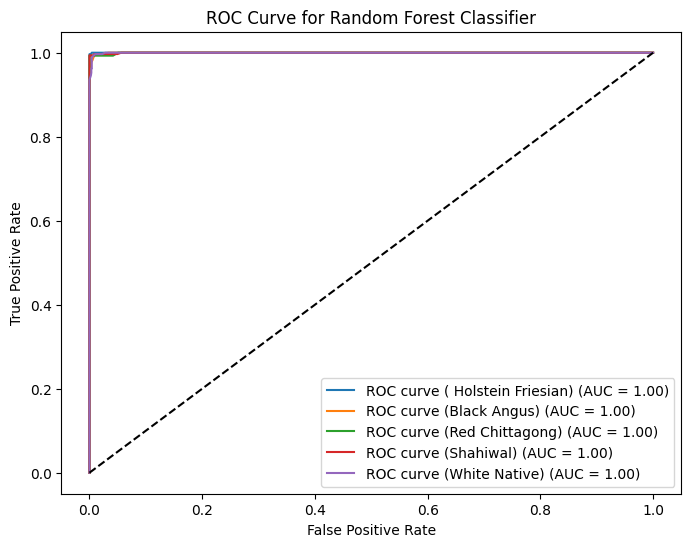

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for ROC curve calculation
num_classes = len(class_names)
val_labels_bin = label_binarize(val_labels, classes=np.arange(num_classes))

# Calculate probabilities for each class
val_probs = rf_model.predict_proba(val_features)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(val_labels_bin[:, i], val_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve ({class_names[i]}) (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier')
plt.legend(loc='lower right')
plt.show()
